In [1]:
!pip install mediapipe opencv-python torch pytube

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of opencv-contrib-python to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 

↗️ Please upload an MP4 video.


Saving Recording 2025-08-14 190427.mp4 to Recording 2025-08-14 190427 (2).mp4
✅ Video received: Recording 2025-08-14 190427 (2).mp4
Video: Recording 2025-08-14 190427 (2).mp4 | 334x454 @ 30.00 fps | 1132 frames


Writing annotated video: 100%|██████████| 1132/1132 [00:47<00:00, 24.07it/s]


✅ Saved 46 risky frames in risk_frames
✅ Risk frames zipped: risk_frames.zip
🎬 Annotated video saved: annotated_output.mp4


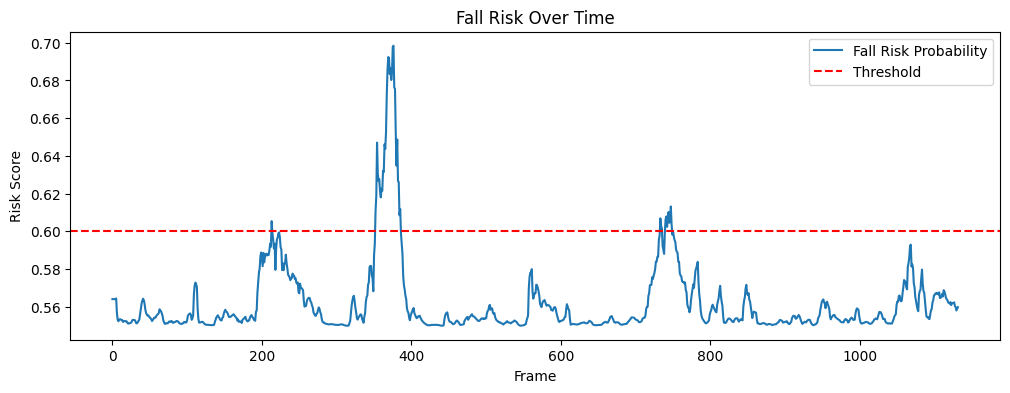

In [3]:
# ============================================
# Fall-Risk Frame Extraction & Visualization
# Google Colab Ready | Python 3.x
# ============================================

# !pip install -q mediapipe opencv-python matplotlib numpy tqdm

import os, shutil, zipfile
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import files
import math

# ----------------------------
# 0) CONFIG
# ----------------------------
CONFIG = {
    "VIDEO_PATH": None,                    # To be set after upload
    "OUTPUT_VIDEO": "annotated_output.mp4",
    "RISK_FRAMES_DIR": "risk_frames",
    "RISK_FRAMES_ZIP": "risk_frames.zip",
    "RISK_THRESHOLD": 0.60,
    "SMOOTHING_WINDOW": 5,
    "MIN_CONSECUTIVE_FRAMES": 3,
    "DRAW_SKELETON": True,
    "FONT_SCALE": 2.0,
    "THICKNESS": 4
}

# ----------------------------
# 1) Upload video (Colab UI)
# ----------------------------
print("↗️ Please upload an MP4 video.")
uploaded = files.upload()
CONFIG["VIDEO_PATH"] = list(uploaded.keys())[0]
print("✅ Video received:", CONFIG["VIDEO_PATH"])
# ----------------------------
# 2) Helpers
# ----------------------------
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def moving_average(x, k):
    if k <= 1: return np.array(x, dtype=float)
    x = np.array(x, dtype=float)
    cumsum = np.cumsum(np.insert(x, 0, 0))
    smoothed = (cumsum[k:] - cumsum[:-k]) / float(k)
    pad_left = [smoothed[0]] * (k - 1)
    return np.array(pad_left + smoothed.tolist())

def angle_between(v1, v2):
    v1 = np.array(v1, dtype=float)
    v2 = np.array(v2, dtype=float)
    n1 = np.linalg.norm(v1); n2 = np.linalg.norm(v2)
    if n1 == 0 or n2 == 0: return 0.0
    cosang = np.clip(np.dot(v1, v2) / (n1 * n2), -1.0, 1.0)
    return math.degrees(math.acos(cosang))

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def ensure_dir(d):
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

# ----------------------------
# 3) Read video metadata
# ----------------------------
cap = cv2.VideoCapture(CONFIG["VIDEO_PATH"])
assert cap.isOpened(), "Failed to open video."

fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video: {CONFIG['VIDEO_PATH']} | {width}x{height} @ {fps:.2f} fps | {total_frames} frames")
# ----------------------------
# 4) Pose + Risk Scoring per frame
# ----------------------------
pose = mp_pose.Pose(static_image_mode=False,
                    model_complexity=1,
                    enable_segmentation=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

risk_scores = []
keypoints_px = []

prev_shoulder_c = None
prev_hip_c = None
hip_y_prev = None

landmark_indices = mp_pose.PoseLandmark

def extract_xy(landmarks, idx):
    lm = landmarks[idx.value]
    return np.array([lm.x, lm.y], dtype=float)

for _ in tqdm(range(total_frames), desc="Analyzing frames"):
    ret, frame = cap.read()
    if not ret or frame is None:
        risk_scores.append(0.0)
        keypoints_px.append((0,0,0,0))
        continue

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        lms = results.pose_landmarks.landmark
        xs = [int(p.x*width) for p in lms]
        ys = [int(p.y*height) for p in lms]
        keypoints_px.append((min(xs), min(ys), max(xs), max(ys)))

        # Centers
        L_SH = extract_xy(lms, landmark_indices.LEFT_SHOULDER)
        R_SH = extract_xy(lms, landmark_indices.RIGHT_SHOULDER)
        L_HIP = extract_xy(lms, landmark_indices.LEFT_HIP)
        R_HIP = extract_xy(lms, landmark_indices.RIGHT_HIP)

        shoulder_c = (L_SH + R_SH)/2
        hip_c = (L_HIP + R_HIP)/2
        trunk_vec = shoulder_c - hip_c
        vertical = np.array([0,1.0])
        trunk_tilt_deg = angle_between(trunk_vec, vertical)

        hip_drop = 0.0
        if hip_y_prev is not None:
            hip_drop = max(0.0, hip_c[1] - hip_y_prev)
        hip_y_prev = hip_c[1]

        shoulder_vel = 0.0
        hip_vel = 0.0
        if prev_shoulder_c is not None:
            shoulder_vel = np.linalg.norm((shoulder_c - prev_shoulder_c)*np.array([width,height]))
        if prev_hip_c is not None:
            hip_vel = np.linalg.norm((hip_c - prev_hip_c)*np.array([width,height]))

        prev_shoulder_c = shoulder_c
        prev_hip_c = hip_c

        tilt_norm = np.clip(trunk_tilt_deg/60.0,0,1)
        vel_norm = np.clip((0.5*shoulder_vel + 0.5*hip_vel)/25.0,0,1)
        drop_norm = np.clip(hip_drop/0.02,0,1)

        z = 1.2*tilt_norm + 0.9*vel_norm + 1.0*drop_norm - 1.0
        risk = float(sigmoid(z))
    else:
        keypoints_px.append((0,0,0,0))
        risk = 0.0

    risk_scores.append(risk)

cap.release()
pose.close()

# ----------------------------
# 5) Smooth & detect risky segments
# ----------------------------
risk_scores = np.array(risk_scores)
risk_smoothed = moving_average(risk_scores, CONFIG["SMOOTHING_WINDOW"])
risk_mask = risk_smoothed >= CONFIG["RISK_THRESHOLD"]
min_k = CONFIG["MIN_CONSECUTIVE_FRAMES"]
final_mask = np.zeros_like(risk_mask, dtype=bool)
count = 0
for i,val in enumerate(risk_mask):
    if val:
        count +=1
    else:
        if count >= min_k:
            final_mask[i-count:i]=True
        count =0
if count>=min_k:
    final_mask[len(risk_mask)-count:len(risk_mask)]=True

# ----------------------------
# 6) Save risky frames + Annotated video
# ----------------------------
ensure_dir(CONFIG["RISK_FRAMES_DIR"])
cap = cv2.VideoCapture(CONFIG["VIDEO_PATH"])
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(CONFIG["OUTPUT_VIDEO"], fourcc, fps, (width,height))

pose = mp_pose.Pose(static_image_mode=False,
                    model_complexity=1,
                    enable_segmentation=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

saved_count = 0
i = 0
for _ in tqdm(range(total_frames), desc="Writing annotated video"):
    ret, frame = cap.read()
    if not ret or frame is None:
        i+=1
        continue

    risky = final_mask[i] if i < len(final_mask) else False
    risk = float(risk_smoothed[i]) if i < len(risk_smoothed) else 0.0

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    res = pose.process(rgb)
    if res.pose_landmarks and CONFIG["DRAW_SKELETON"]:
        mp_drawing.draw_landmarks(frame,res.pose_landmarks,mp_pose.POSE_CONNECTIONS)

    # ------------------------
    # Draw big centered text
    # ------------------------
    text = f"⚠ High Fall Risk: {risk:.2f}" if risky else f"Safe: {risk:.2f}"
    (text_w,text_h),_ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, CONFIG["FONT_SCALE"], CONFIG["THICKNESS"])
    x = (width - text_w)//2
    y = height//2
    # rectangle background
    bg_color = (255,255,255)
    text_color = (0,0,255) if risky else (0,200,0)
    cv2.rectangle(frame, (x-10,y-text_h-10),(x+text_w+10,y+10), bg_color,-1)
    cv2.putText(frame,text,(x,y),cv2.FONT_HERSHEY_SIMPLEX,CONFIG["FONT_SCALE"],text_color,CONFIG["THICKNESS"])

    # save risky frames
    if risky:
        out_path = os.path.join(CONFIG["RISK_FRAMES_DIR"],f"frame_{i:06d}_risk_{risk:.2f}.jpg")
        cv2.imwrite(out_path,frame)
        saved_count+=1

    out.write(frame)
    i+=1

cap.release()
out.release()
pose.close()

# Zip risky frames
if saved_count>0:
    with zipfile.ZipFile(CONFIG["RISK_FRAMES_ZIP"],'w',zipfile.ZIP_DEFLATED) as zipf:
        for fn in sorted(os.listdir(CONFIG["RISK_FRAMES_DIR"])):
            zipf.write(os.path.join(CONFIG["RISK_FRAMES_DIR"],fn))
    print(f"✅ Saved {saved_count} risky frames in {CONFIG['RISK_FRAMES_DIR']}")
    print(f"✅ Risk frames zipped: {CONFIG['RISK_FRAMES_ZIP']}")
print(f"🎬 Annotated video saved: {CONFIG['OUTPUT_VIDEO']}")

# ----------------------------
# 7) Plot risk curve
# ----------------------------
plt.figure(figsize=(12,4))
plt.plot(risk_smoothed,label='Fall Risk Probability')
plt.axhline(CONFIG["RISK_THRESHOLD"],color='r',linestyle='--',label='Threshold')
plt.xlabel("Frame")
plt.ylabel("Risk Score")
plt.title("Fall Risk Over Time")
plt.legend()
plt.show()

In [9]:
# ============================================
# Fall-Risk Frame Extraction & Visualization
# Google Colab Ready | Python 3.x
# ============================================

# !pip install -q mediapipe opencv-python matplotlib numpy tqdm

import os, shutil, zipfile
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import files
import math

# ----------------------------
# 0) CONFIG
# ----------------------------
CONFIG = {
    "VIDEO_PATH": None,
    "OUTPUT_VIDEO": "annotated_output.mp4",
    "RISK_FRAMES_DIR": "risk_frames",
    "RISK_FRAMES_ZIP": "risk_frames.zip",
    "RISK_THRESHOLD": 0.60,
    "SMOOTHING_WINDOW": 5,
    "MIN_CONSECUTIVE_FRAMES": 3,
    "DRAW_SKELETON": True,
    "FONT_SCALE": 1,     # smaller for clarity
    "THICKNESS": 1         # slightly thinner
}

# ----------------------------
# 1) Upload video (Colab UI)
# ----------------------------
print("↗️ Please upload an MP4 video.")
uploaded = files.upload()
CONFIG["VIDEO_PATH"] = list(uploaded.keys())[0]
print("✅ Video received:", CONFIG["VIDEO_PATH"])

# ----------------------------
# 2) Helpers
# ----------------------------
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def moving_average(x, k):
    if k <= 1: return np.array(x, dtype=float)
    x = np.array(x, dtype=float)
    cumsum = np.cumsum(np.insert(x, 0, 0))
    smoothed = (cumsum[k:] - cumsum[:-k]) / float(k)
    pad_left = [smoothed[0]] * (k - 1)
    return np.array(pad_left + smoothed.tolist())

def angle_between(v1, v2):
    v1 = np.array(v1, dtype=float)
    v2 = np.array(v2, dtype=float)
    n1 = np.linalg.norm(v1); n2 = np.linalg.norm(v2)
    if n1 == 0 or n2 == 0: return 0.0
    cosang = np.clip(np.dot(v1, v2) / (n1 * n2), -1.0, 1.0)
    return math.degrees(math.acos(cosang))

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def ensure_dir(d):
    if os.path.exists(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

# ----------------------------
# 3) Read video metadata
# ----------------------------
cap = cv2.VideoCapture(CONFIG["VIDEO_PATH"])
assert cap.isOpened(), "Failed to open video."

fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"Video: {CONFIG['VIDEO_PATH']} | {width}x{height} @ {fps:.2f} fps | {total_frames} frames")

# ----------------------------
# 4) Pose + Risk Scoring per frame
# ----------------------------
pose = mp_pose.Pose(static_image_mode=False,
                    model_complexity=1,
                    enable_segmentation=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

risk_scores = []
keypoints_px = []

prev_shoulder_c = None
prev_hip_c = None
hip_y_prev = None

landmark_indices = mp_pose.PoseLandmark

def extract_xy(landmarks, idx):
    lm = landmarks[idx.value]
    return np.array([lm.x, lm.y], dtype=float)

for _ in tqdm(range(total_frames), desc="Analyzing frames"):
    ret, frame = cap.read()
    if not ret or frame is None:
        risk_scores.append(0.0)
        keypoints_px.append((0,0,0,0))
        continue

    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    if results.pose_landmarks:
        lms = results.pose_landmarks.landmark
        xs = [int(p.x*width) for p in lms]
        ys = [int(p.y*height) for p in lms]
        keypoints_px.append((min(xs), min(ys), max(xs), max(ys)))

        # Centers
        L_SH = extract_xy(lms, landmark_indices.LEFT_SHOULDER)
        R_SH = extract_xy(lms, landmark_indices.RIGHT_SHOULDER)
        L_HIP = extract_xy(lms, landmark_indices.LEFT_HIP)
        R_HIP = extract_xy(lms, landmark_indices.RIGHT_HIP)

        shoulder_c = (L_SH + R_SH)/2
        hip_c = (L_HIP + R_HIP)/2
        trunk_vec = shoulder_c - hip_c
        vertical = np.array([0,1.0])
        trunk_tilt_deg = angle_between(trunk_vec, vertical)

        hip_drop = 0.0
        if hip_y_prev is not None:
            hip_drop = max(0.0, hip_c[1] - hip_y_prev)
        hip_y_prev = hip_c[1]

        shoulder_vel = 0.0
        hip_vel = 0.0
        if prev_shoulder_c is not None:
            shoulder_vel = np.linalg.norm((shoulder_c - prev_shoulder_c)*np.array([width,height]))
        if prev_hip_c is not None:
            hip_vel = np.linalg.norm((hip_c - prev_hip_c)*np.array([width,height]))

        prev_shoulder_c = shoulder_c
        prev_hip_c = hip_c

        tilt_norm = np.clip(trunk_tilt_deg/60.0,0,1)
        vel_norm = np.clip((0.5*shoulder_vel + 0.5*hip_vel)/25.0,0,1)
        drop_norm = np.clip(hip_drop/0.02,0,1)

        z = 1.2*tilt_norm + 0.9*vel_norm + 1.0*drop_norm - 1.0
        risk = float(sigmoid(z))
    else:
        keypoints_px.append((0,0,0,0))
        risk = 0.0

    risk_scores.append(risk)

cap.release()
pose.close()

# ----------------------------
# 5) Smooth & detect risky segments
# ----------------------------
risk_scores = np.array(risk_scores)
risk_smoothed = moving_average(risk_scores, CONFIG["SMOOTHING_WINDOW"])
risk_mask = risk_smoothed >= CONFIG["RISK_THRESHOLD"]
min_k = CONFIG["MIN_CONSECUTIVE_FRAMES"]
final_mask = np.zeros_like(risk_mask, dtype=bool)
count = 0
for i,val in enumerate(risk_mask):
    if val:
        count +=1
    else:
        if count >= min_k:
            final_mask[i-count:i]=True
        count =0
if count>=min_k:
    final_mask[len(risk_mask)-count:len(risk_mask)]=True

# ----------------------------
# 6) Save risky frames + Annotated video
# ----------------------------
ensure_dir(CONFIG["RISK_FRAMES_DIR"])
cap = cv2.VideoCapture(CONFIG["VIDEO_PATH"])
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(CONFIG["OUTPUT_VIDEO"], fourcc, fps, (width,height))

pose = mp_pose.Pose(static_image_mode=False,
                    model_complexity=1,
                    enable_segmentation=False,
                    min_detection_confidence=0.5,
                    min_tracking_confidence=0.5)

saved_count = 0
i = 0
for _ in tqdm(range(total_frames), desc="Writing annotated video"):
    ret, frame = cap.read()
    if not ret or frame is None:
        i+=1
        continue

    risky = final_mask[i] if i < len(final_mask) else False
    risk = float(risk_smoothed[i]) if i < len(risk_smoothed) else 0.0

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    res = pose.process(rgb)
    if res.pose_landmarks and CONFIG["DRAW_SKELETON"]:
        mp_drawing.draw_landmarks(frame,res.pose_landmarks,mp_pose.POSE_CONNECTIONS)

    # ------------------------
    # Draw centered text (smaller & clearer)
    # ------------------------
    text = f"⚠ High Fall Risk: {risk:.2f}" if risky else f"Safe: {risk:.2f}"
    font_scale = CONFIG["FONT_SCALE"]
    thickness = CONFIG["THICKNESS"]

    (text_w, text_h), _ = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, font_scale, thickness)
    x = (width - text_w)//2
    y = height//2

    # rectangle background (tight)
    padding = 5
    bg_color = (255, 255, 255)
    text_color = (0, 0, 255) if risky else (0, 200, 0)
    cv2.rectangle(frame, (x-padding, y-text_h-padding), (x+text_w+padding, y+padding), bg_color, -1)

    # put text with anti-aliasing
    cv2.putText(frame, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, font_scale, text_color, thickness, lineType=cv2.LINE_AA)

    # save risky frames
    if risky:
        out_path = os.path.join(CONFIG["RISK_FRAMES_DIR"],f"frame_{i:06d}_risk_{risk:.2f}.jpg")
        cv2.imwrite(out_path,frame)
        saved_count+=1

    out.write(frame)
    i+=1

cap.release()
out.release()
pose.close()

# Zip risky frames
if saved_count>0:
    with zipfile.ZipFile(CONFIG["RISK_FRAMES_ZIP"],'w',zipfile.ZIP_DEFLATED) as zipf:
        for fn in sorted(os.listdir(CONFIG["RISK_FRAMES_DIR"])):
            zipf.write(os.path.join(CONFIG["RISK_FRAMES_DIR"],fn))
    print(f"✅ Saved {saved_count} risky frames in {CONFIG['RISK_FRAMES_DIR']}")
    print(f"✅ Risk frames zipped: {CONFIG['RISK_FRAMES_ZIP']}")
print(f"🎬 Annotated video saved: {CONFIG['OUTPUT_VIDEO']}")

↗️ Please upload an MP4 video.


Saving Recording 2025-08-14 190301.mp4 to Recording 2025-08-14 190301.mp4
✅ Video received: Recording 2025-08-14 190301.mp4
Video: Recording 2025-08-14 190301.mp4 | 784x342 @ 30.00 fps | 1147 frames


Writing annotated video: 100%|██████████| 1147/1147 [00:48<00:00, 23.54it/s]


✅ Saved 56 risky frames in risk_frames
✅ Risk frames zipped: risk_frames.zip
🎬 Annotated video saved: annotated_output.mp4


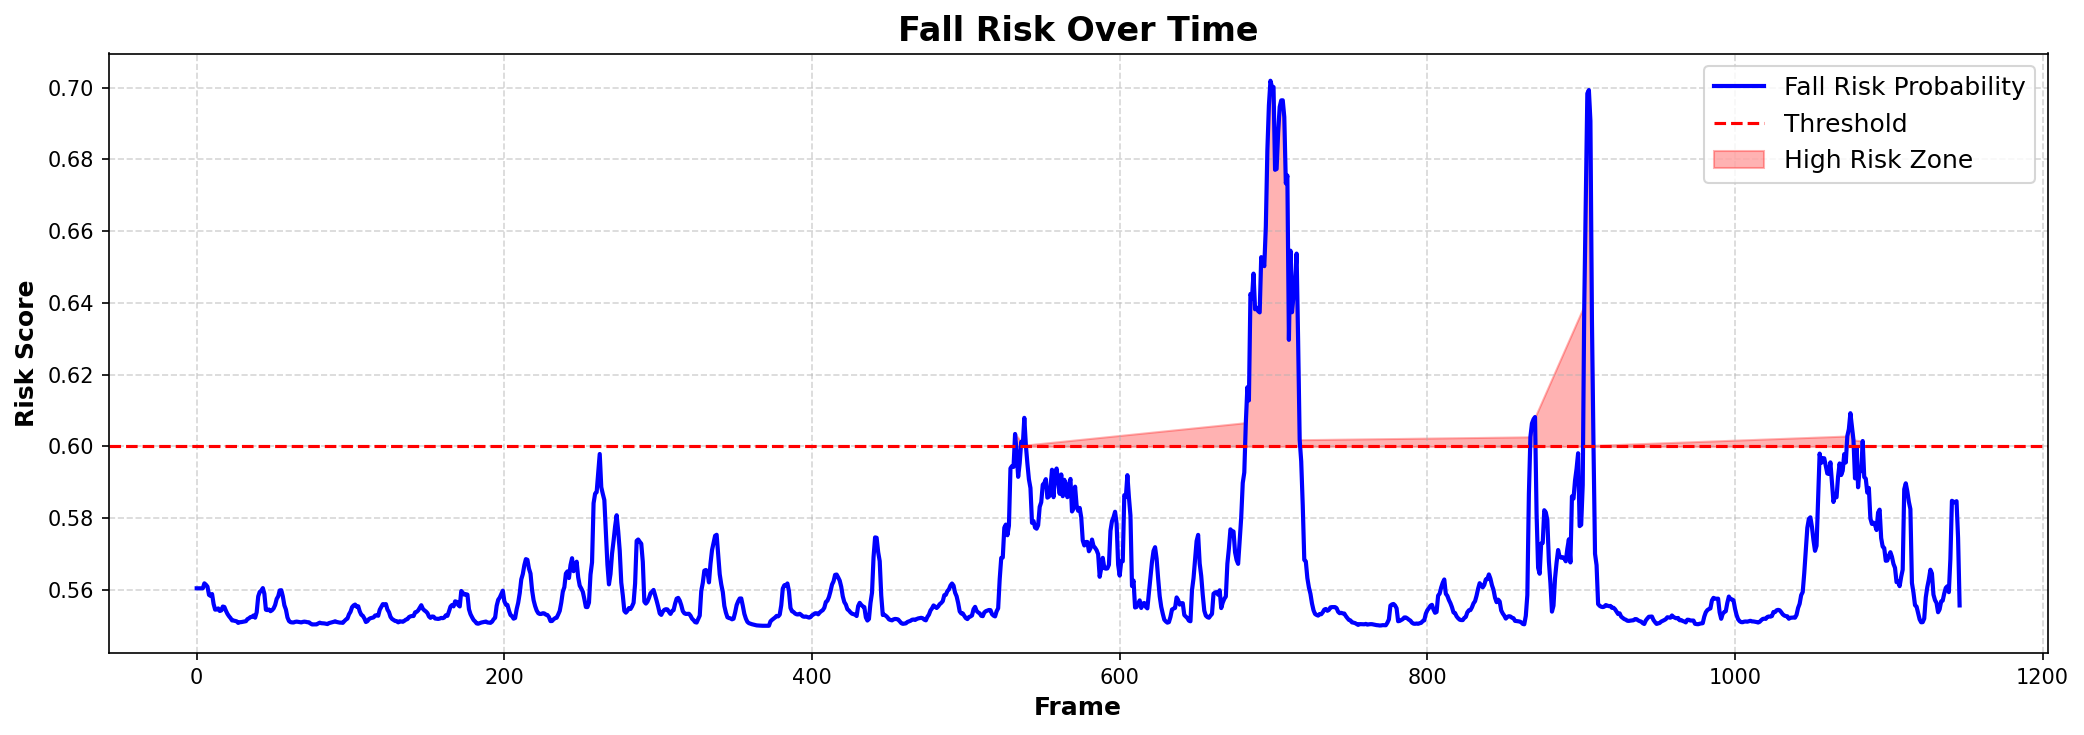

In [10]:
# ----------------------------
# 7) Plot risk curve (high-quality academic style)
# ----------------------------
plt.figure(figsize=(14,5), dpi=150)  # أكبر وأوضح
plt.plot(risk_smoothed, label='Fall Risk Probability', color='blue', linewidth=2)

# Threshold line
plt.axhline(CONFIG["RISK_THRESHOLD"], color='red', linestyle='--', linewidth=1.5, label='Threshold')

# Highlight high-risk frames
high_risk_indices = np.where(risk_smoothed >= CONFIG["RISK_THRESHOLD"])[0]
plt.fill_between(high_risk_indices, CONFIG["RISK_THRESHOLD"], risk_smoothed[high_risk_indices],
                 color='red', alpha=0.3, label='High Risk Zone')

# Axes labels & title
plt.xlabel("Frame", fontsize=12, fontweight='bold')
plt.ylabel("Risk Score", fontsize=12, fontweight='bold')
plt.title("Fall Risk Over Time", fontsize=16, fontweight='bold')

# Grid, legend, layout
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)
plt.tight_layout()

# Show
plt.show()


In [6]:
import cv2

# Load image
img = cv2.imread("/content/download (3).png")

# Resize to 4K
img_4k = cv2.resize(img, (3840, 2160), interpolation=cv2.INTER_CUBIC)

# Save
cv2.imwrite("frame_4k.jpg", img_4k)

True

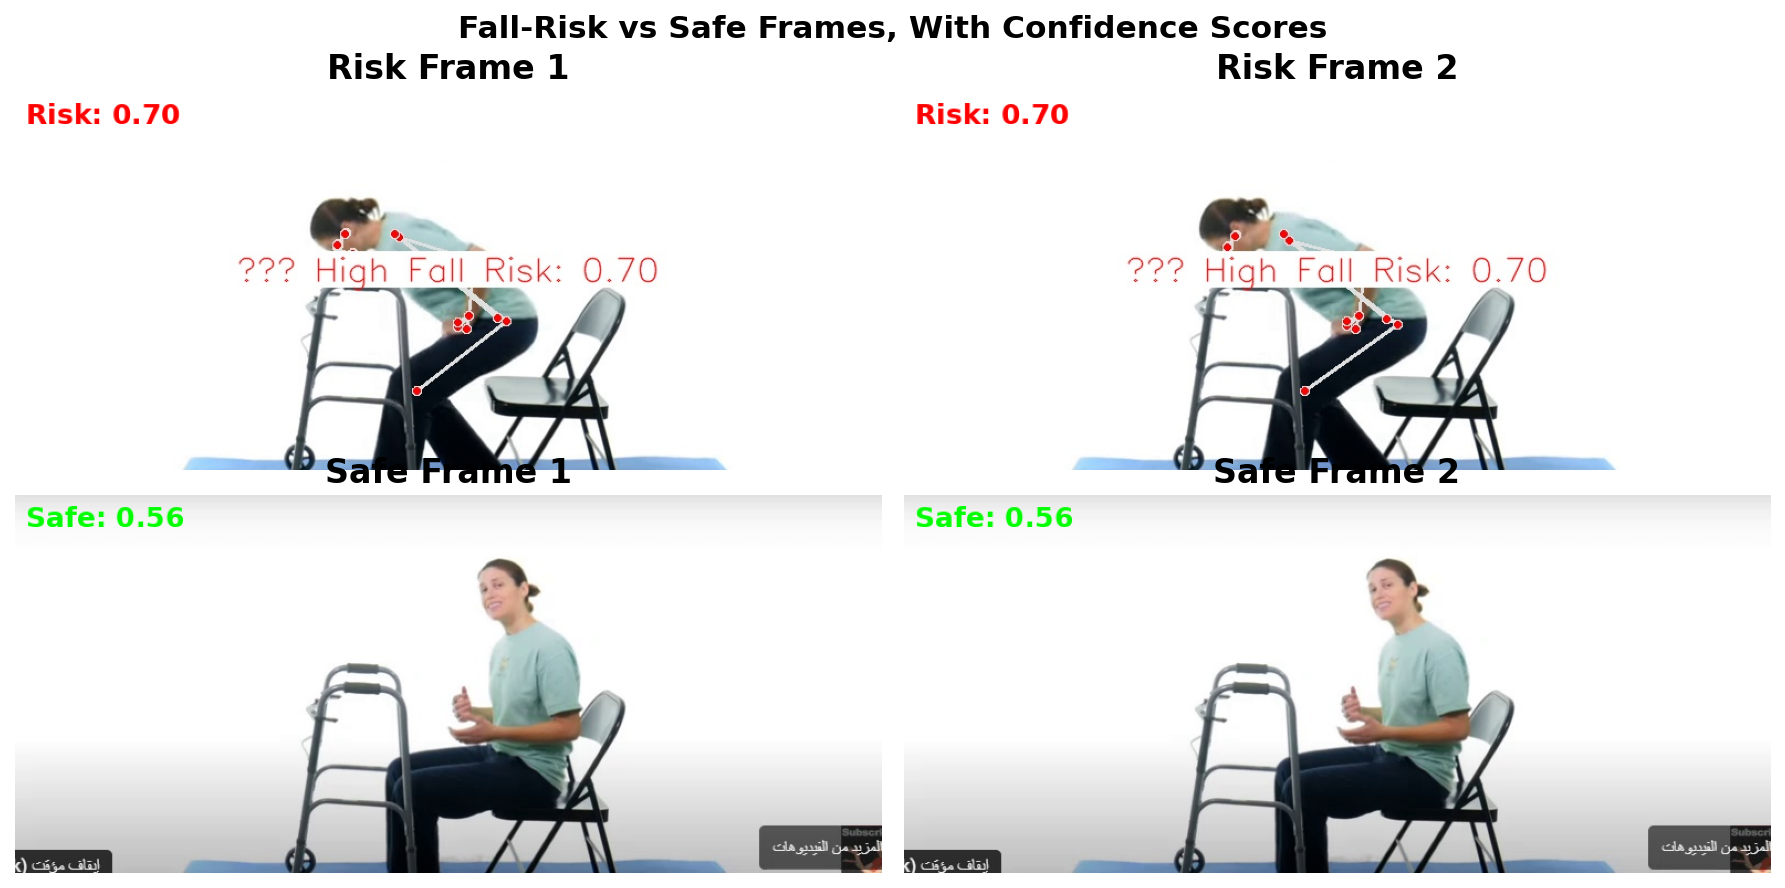

In [11]:
import glob
import os
import cv2
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import font_manager

# ----------------------------
# Function to load bold font reliably
# ----------------------------
def get_bold_font(font_size):
    try:
        # Use Matplotlib's bundled DejaVu Sans Bold font
        dejavu_path = font_manager.findfont("DejaVu Sans:bold")
        return ImageFont.truetype(dejavu_path, font_size)
    except Exception as e:
        print(f"⚠ Font load failed, using default: {e}")
        return ImageFont.load_default()
# ----------------------------
# Function to add text to image (top-left + optional smaller center)
# ----------------------------

def add_text_to_image(image_path, text, font_size=18, color=(255,0,0), center_note=None):
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    font = get_bold_font(font_size)

    # Top-left label (Risk/Safe)
    draw.text((10, 5), text, fill=color, font=font)

    # Optional center label (smaller & repositioned)
    if center_note:
        center_font = get_bold_font(14)  # smaller font size
        w, h = img.size
        try:
            bbox = draw.textbbox((0, 0), center_note, font=center_font)
            text_w, text_h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        except AttributeError:
            text_w, text_h = draw.textsize(center_note, font=center_font)

        # Position: a bit above center (adjust + or - 50)
        # draw.text(((w - text_w) / 2, (h - text_h) / 2 - 50),
        #           center_note, fill=color, font=center_font)

    return img


# ----------------------------
# Get risky frame images
# ----------------------------
risk_images = sorted(glob.glob(os.path.join(CONFIG["RISK_FRAMES_DIR"], "*.jpg")))
# ----------------------------
# Get safe frames from video
# ----------------------------
safe_images = []
video_cap = cv2.VideoCapture(CONFIG["VIDEO_PATH"])
frame_idx = 0
while len(safe_images) < 5 and video_cap.isOpened():
    ret, frame = video_cap.read()
    if not ret:
        break
    risk_val = float(risk_smoothed[frame_idx]) if frame_idx < len(risk_smoothed) else 0.0
    if risk_val < CONFIG["RISK_THRESHOLD"]:
        safe_path = f"safe_frame_{frame_idx:06d}_risk_{risk_val:.2f}.jpg"
        cv2.imwrite(safe_path, frame)
        safe_images.append(safe_path)
    frame_idx += 1
video_cap.release()
# ----------------------------
# Plot results
# ----------------------------
if risk_images:
    # Top risky frames (sorted by highest risk score)
    risk_images_sorted = sorted(
        risk_images,
        key=lambda x: float(x.split("_risk_")[1].replace(".jpg", "")),
        reverse=True
    )
    top_risk_images = risk_images_sorted[:2]
    top_safe_images = safe_images[:2]

    plt.figure(figsize=(12, 6), dpi=150)  # Higher DPI for sharper text

    # Risk frames
    for idx, img_path in enumerate(top_risk_images):
        risk_val = float(img_path.split("_risk_")[1].replace(".jpg", ""))
        img_with_text = add_text_to_image(
            img_path,
            f"Risk: {risk_val:.2f}",
            font_size=25,
            color=(255, 0, 0),
            center_note="High Fall Risk"  # smaller center label
        )
        plt.subplot(2, 2, idx + 1)
        plt.imshow(img_with_text)
        plt.axis("off")
        plt.title(f"Risk Frame {idx + 1}", fontsize=16, fontweight='bold')

    # Safe frames
    for idx, img_path in enumerate(top_safe_images):
        risk_val = float(img_path.split("_risk_")[1].replace(".jpg", ""))
        img_with_text = add_text_to_image(
            img_path,
            f"Safe: {risk_val:.2f}",
            font_size=25,
            color=(0, 255, 0),
            center_note="Safe Posture"  # smaller center label
        )
        plt.subplot(2, 2, idx + 3)
        plt.imshow(img_with_text)
        plt.axis("off")
        plt.title(f"Safe Frame {idx + 1}", fontsize=16, fontweight='bold')
    plt.suptitle(
        "Fall-Risk vs Safe Frames, With Confidence Scores",
        fontsize=15,
        fontweight='bold'
    )
    plt.tight_layout()
    plt.show()

else:
    print("⚠ No risky frames found to display.")


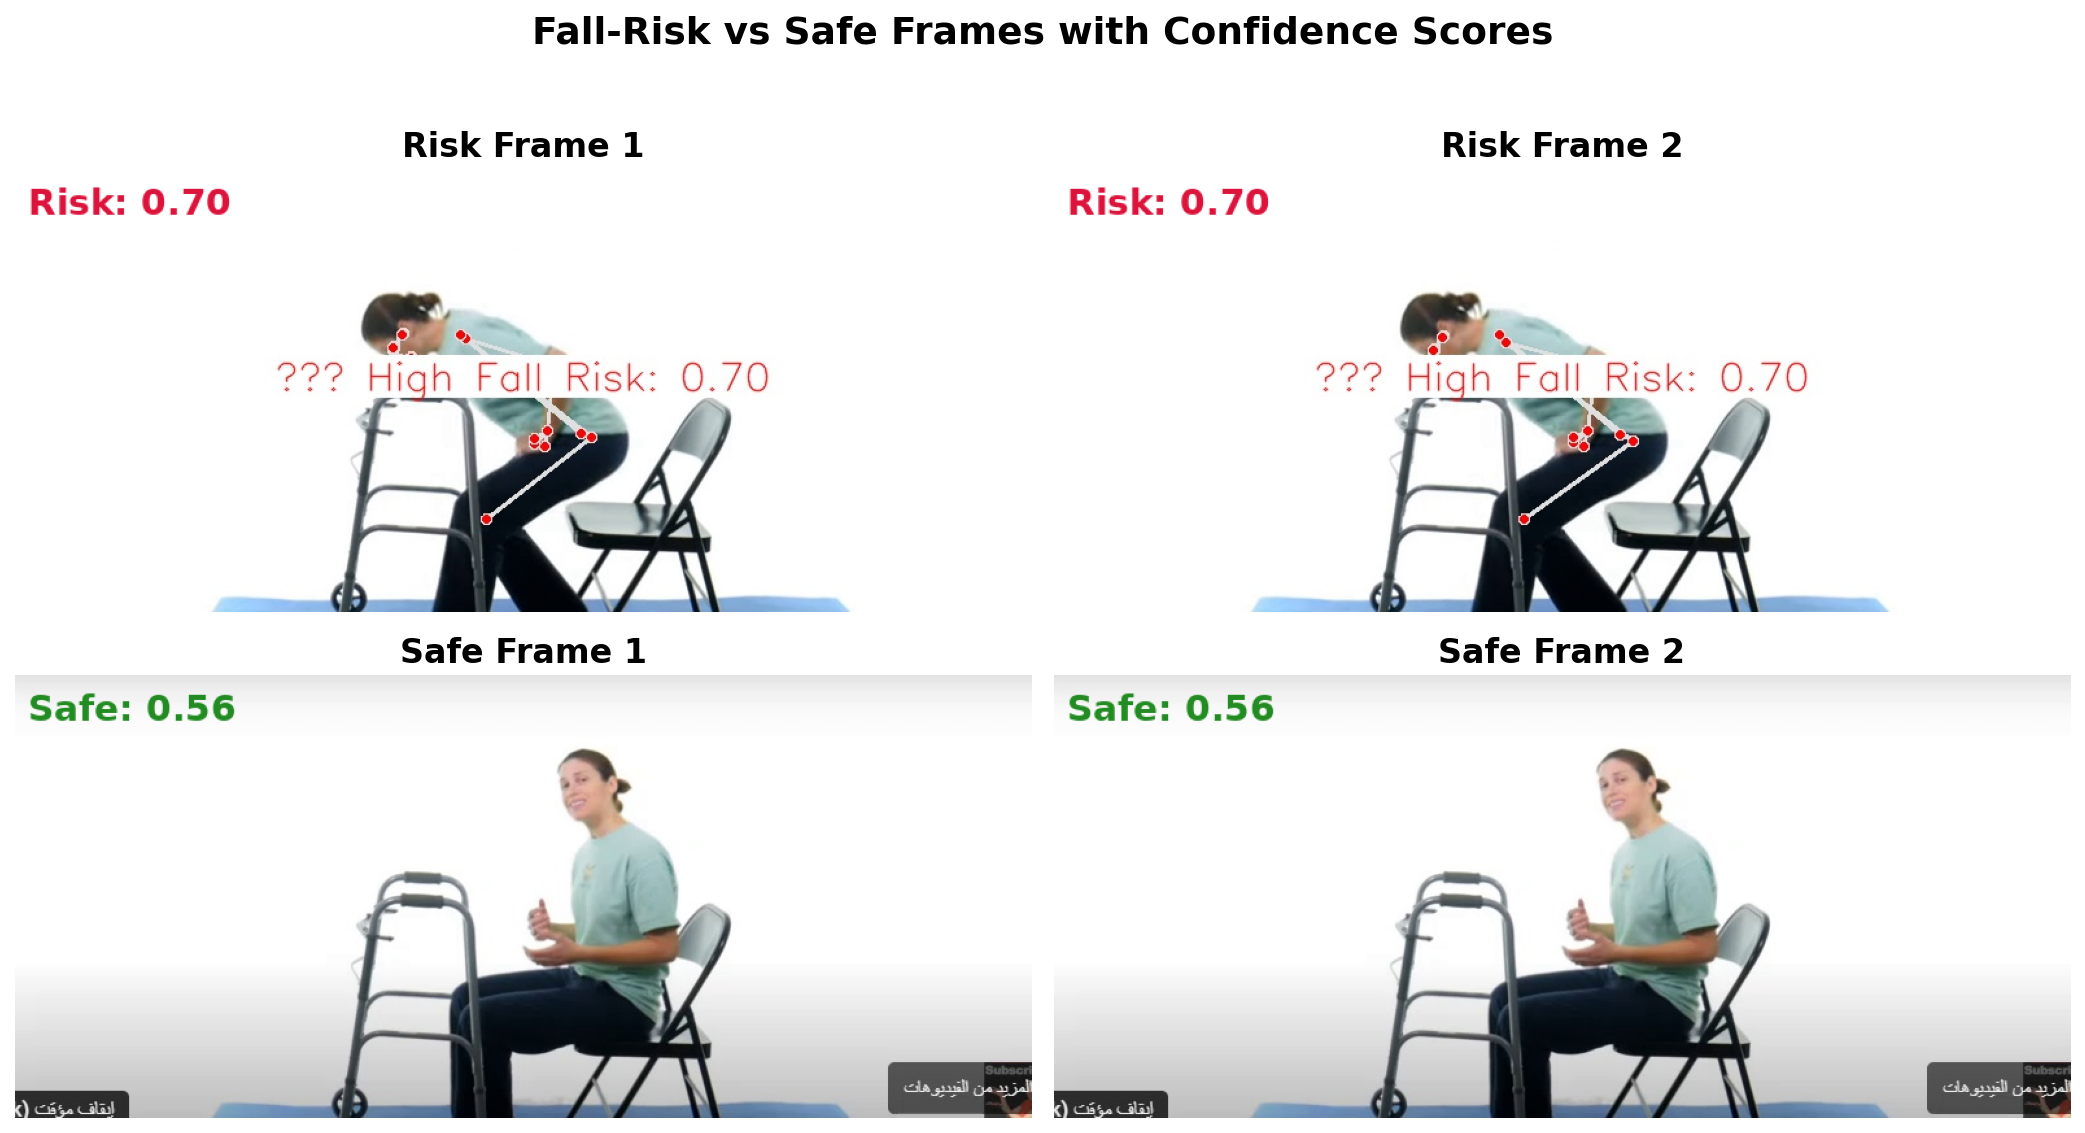

In [16]:
import glob
import os
import cv2
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
from matplotlib import font_manager

# ----------------------------
# Function to load bold font reliably
# ----------------------------
def get_bold_font(font_size):
    try:
        dejavu_path = font_manager.findfont("DejaVu Sans:bold")
        return ImageFont.truetype(dejavu_path, font_size)
    except Exception as e:
        print(f"⚠ Font load failed, using default: {e}")
        return ImageFont.load_default()

# ----------------------------
# Function to add text to image (top-left + optional smaller center)
# ----------------------------
def add_text_to_image(image_path, text, font_size=18, color=(255,0,0), center_note=None):
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    font = get_bold_font(font_size)

    # Top-left label (Risk/Safe)
    draw.text((10, 10), text, fill=color, font=font)

    # Optional center label (smaller & repositioned)
    if center_note:
        center_font = get_bold_font(max(14, font_size-8))  # smaller font relative to main
        w, h = img.size
        try:
            bbox = draw.textbbox((0, 0), center_note, font=center_font)
            text_w, text_h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        except AttributeError:
            text_w, text_h = draw.textsize(center_note, font=center_font)

        # Position: slightly above center
        draw.text(((w - text_w) / 2, (h - text_h) / 2 - 40),
                  center_note, fill=color, font=center_font)

    return img

# ----------------------------
# Get risky frame images
# ----------------------------
risk_images = sorted(glob.glob(os.path.join(CONFIG["RISK_FRAMES_DIR"], "*.jpg")))

# ----------------------------
# Get safe frames from video
# ----------------------------
safe_images = []
video_cap = cv2.VideoCapture(CONFIG["VIDEO_PATH"])
frame_idx = 0
while len(safe_images) < 5 and video_cap.isOpened():
    ret, frame = video_cap.read()
    if not ret:
        break
    risk_val = float(risk_smoothed[frame_idx]) if frame_idx < len(risk_smoothed) else 0.0
    if risk_val < CONFIG["RISK_THRESHOLD"]:
        safe_path = f"safe_frame_{frame_idx:06d}_risk_{risk_val:.2f}.jpg"
        cv2.imwrite(safe_path, frame)
        safe_images.append(safe_path)
    frame_idx += 1
video_cap.release()

# ----------------------------
# Plot results (Academic Style)
# ----------------------------
if risk_images:
    # Top risky frames (highest risk)
    risk_images_sorted = sorted(
        risk_images,
        key=lambda x: float(x.split("_risk_")[1].replace(".jpg", "")),
        reverse=True
    )
    top_risk_images = risk_images_sorted[:2]
    top_safe_images = safe_images[:2]

    plt.figure(figsize=(14, 8), dpi=150)  # higher DPI for clarity

    # Risk frames
    for idx, img_path in enumerate(top_risk_images):
        risk_val = float(img_path.split("_risk_")[1].replace(".jpg", ""))
        img_with_text = add_text_to_image(
            img_path,
            f"Risk: {risk_val:.2f}",
            font_size=28,
            color=(220, 20, 60),  # Crimson Red for high risk
            # center_note="High Fall Risk"
        )
        plt.subplot(2, 2, idx + 1)
        plt.imshow(img_with_text)
        plt.axis("off")
        plt.title(f"Risk Frame {idx + 1}", fontsize=16, fontweight='bold', color='black')

    # Safe frames
    for idx, img_path in enumerate(top_safe_images):
        risk_val = float(img_path.split("_risk_")[1].replace(".jpg", ""))
        img_with_text = add_text_to_image(
            img_path,
            f"Safe: {risk_val:.2f}",
            font_size=28,
            color=(34, 139, 34),  # Forest Green for safe
            # center_note="Safe Posture"
        )
        plt.subplot(2, 2, idx + 3)
        plt.imshow(img_with_text)
        plt.axis("off")
        plt.title(f"Safe Frame {idx + 1}", fontsize=16, fontweight='bold', color='black')

    plt.suptitle(
        "Fall-Risk vs Safe Frames with Confidence Scores",
        fontsize=18,
        fontweight='bold'
    )
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

else:
    print("⚠ No risky frames found to display.")


In [17]:
import cv2

# Load image
img = cv2.imread("/content/download (1).png")

# Resize to 4K
img_4k = cv2.resize(img, (3840, 2160), interpolation=cv2.INTER_CUBIC)

# Save
cv2.imwrite("frame_4k.jpg", img_4k)

True